In [1]:
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    GPT2Config,
    Trainer,
    TrainingArguments
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/user/j.lautenschlager/u25037/language-as-data/.311_venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# load SST-2 validation set
dataset = load_dataset("glue", "sst2", split="validation")
metric = evaluate.load("accuracy")

# load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-sst2-finetuned/gpt2_sst2_model")

def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, max_length=128)

encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print(f"Validation samples: {len(encoded_dataset)}")

Validation samples: 872


In [3]:
finetuned_model = GPT2ForSequenceClassification.from_pretrained("./gpt2-sst2-finetuned/gpt2_sst2_model")
finetuned_model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [4]:
# fine tuned model
model_finetuned = GPT2ForSequenceClassification.from_pretrained("./gpt2-sst2-finetuned/gpt2_sst2_model")
model_finetuned.to(device)

# frozen backbone model
model_frozen = GPT2ForSequenceClassification.from_pretrained("./gpt2-sst2-frozen/gpt2_sst2_frozen_model")
model_frozen.to(device)

# randomly initialized model
config = GPT2Config.from_pretrained("gpt2", num_labels=2)
model_random = GPT2ForSequenceClassification(config)
model_random.to(device)

# ensure all models use same padding token
model_random.config.pad_token_id = tokenizer.pad_token_id

In [5]:
def evaluate_model(model, dataset, name):
    print(f"Evaluating {name}...")
    
    trainer = Trainer(
        model=model,
        eval_dataset=dataset,
        tokenizer=tokenizer,
        compute_metrics=lambda p: metric.compute(
            predictions=np.argmax(p.predictions, axis=-1), 
            references=p.label_ids
        )
    )
    
    results = trainer.evaluate()
    print(f"-> {name} Accuracy: {results['eval_accuracy']:.4f}")
    return results['eval_accuracy']

In [6]:
acc_random = evaluate_model(model_random, encoded_dataset, "Random Baseline")
acc_frozen = evaluate_model(model_frozen, encoded_dataset, "Frozen Backbone")
acc_finetuned = evaluate_model(model_finetuned, encoded_dataset, "Full Fine-Tune")

/tmp/ipykernel_4119809/3538074766.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Evaluating Random Baseline...


/user/j.lautenschlager/u25037/language-as-data/.311_venv/lib64/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/tmp/ipykernel_4119809/3538074766.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


-> Random Baseline Accuracy: 0.4794
Evaluating Frozen Backbone...


/user/j.lautenschlager/u25037/language-as-data/.311_venv/lib64/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/tmp/ipykernel_4119809/3538074766.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


-> Frozen Backbone Accuracy: 0.8406
Evaluating Full Fine-Tune...


/user/j.lautenschlager/u25037/language-as-data/.311_venv/lib64/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


-> Full Fine-Tune Accuracy: 0.9128


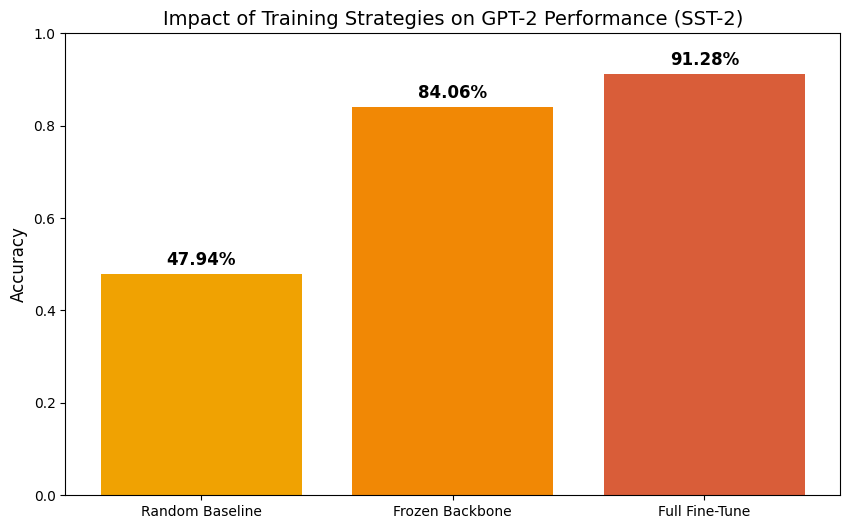

In [7]:
models = ['Random Baseline', 'Frozen Backbone', 'Full Fine-Tune']
accuracies = [acc_random, acc_frozen, acc_finetuned]
colors = ['#F0A202', '#F18805', '#D95D39'] # orange shades

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors)
plt.title('Impact of Training Strategies on GPT-2 Performance (SST-2)', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0) 

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

In [ ]:
import pandas as pd

# easy and hard samples IDs from the SST-2 training set
samples_to_test = {
    "EASY": [16, 18, 20, 33, 49, 78, 120, 256, 7944, 67071],
    "HARD": [7, 44, 79, 86, 202, 242, 287, 7744, 17688, 20839]
}

train_dataset = load_dataset("glue", "sst2", split="train")

def get_prediction(model, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    pred_idx = outputs.logits.argmax().item()
    return "POSITIVE" if pred_idx == 1 else "NEGATIVE"

label_map = {1: "POSITIVE", 0: "NEGATIVE"}

results_data = []

for difficulty, ids in samples_to_test.items():
    for example_id in ids:
        data = train_dataset[example_id]
        text = data['sentence']
        ground_truth = label_map[data['label']]
        
        # get predictions from all 3 models
        pred_random = get_prediction(model_random, text)
        pred_frozen = get_prediction(model_frozen, text)
        pred_finetuned = get_prediction(model_finetuned, text)
        
        results_data.append({
            "Difficulty": difficulty,
            "ID": example_id,
            "Text": f'"{text}"', 
            "Ground Truth": ground_truth,
            "Random Model": pred_random,
            "Frozen Model": pred_frozen,
            "Full Fine-Tune": pred_finetuned
        })

df_results = pd.DataFrame(results_data)
pd.set_option('display.max_colwidth', None) # Show full text
display(df_results)

Running predictions on specific instances...


,Difficulty,ID,Text,Ground Truth,Random Model,Frozen Model,Full Fine-Tune
0,EASY,16,"""cold movie """,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE
1,EASY,18,"""redundant concept """,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE
2,EASY,20,"""equals the original and in some ways even betters it """,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
3,EASY,33,"""by far the worst movie of the year """,NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE
4,EASY,49,"""disappointments """,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE
5,EASY,78,"""contains very few laughs and even less surprises """,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE
6,EASY,120,"""very well-written and very well-acted . """,POSITIVE,POSITIVE,POSITIVE,POSITIVE
7,EASY,256,"""halfway through this picture i was beginning to hate it """,NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE
8,EASY,7944,"""no """,NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE
9,EASY,67071,"""fun """,POSITIVE,POSITIVE,POSITIVE,POSITIVE
